In [1]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import yfinance as yf
import nbformat
import plotly.express as px
#pd.options.plotting.backend = "plotly"
from src.trainer import Trainer
from src.lstmpf import NN_Sharpe
from src.viz import plot_results

# Building a simple strategy with LSTM


Now we want to make a strategy with the LSTM on a simple framework.

---

Suppose we have $n=4$ assets and we want to construct a portfolio each day, we will implement the strategy detailed in this [paper](https://arxiv.org/pdf/2005.13665) (Zhang & Al 2021). We have the following strategy:

* First we select a training period where we train a model to predict the weights of a portfolio that maximise the Sharpe Ratio

* Then we test it on the test period (no overlap between the training set and the test set), with the weights predicted, we can compute the sharpe ratio and the annualized return of the strategy


In a first place, we will test it on synthetic data, generated from a Multivariate Gaussian distribution. Under this setup, we know that the Markowitz portfolio maximize the Sharpe Ratio

# Synthetic Data

We use a simple method to generate some synthetic data. We suppose that the return of an asset follows a gaussian distribution, and has a dependancy with the other assets

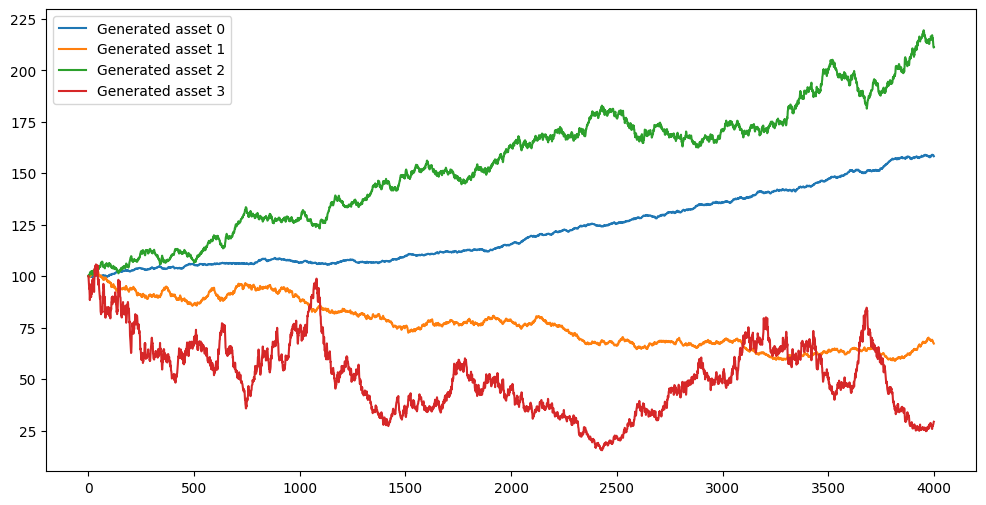

In [3]:
np.random.seed(702)

n=4000

mu = np.array([ 0.01056076, 0.00248467,  0.02553161,  0.01009022]) /100
Sigma = np.array([[ 1.01405883e-01, -9.62692257e-03, -3.00656688e-02,
        2.62421178e-01],
    [-9.62692257e-03,  1.47484256e-00,  7.06655188e-01,
        -3.29981888e+00],
    [-3.00656688e-02,  7.06655188e-01,  1.63707741e+00,
        -7.46659065e+00],
    [ 2.62421178e-01, -3.29981888e+00, -7.46659065e+00,
        6.53481930e+01]])/100000

increments = np.random.multivariate_normal(mu, Sigma, size=n)

values = np.ones((n, 4))*100

for t in range(1, n):
    values[t] = values[t-1] * (1 + increments[t])

plt.figure(figsize=(12,6))
for i in range(4):
    plt.plot(values[:,i], label=f"Generated asset {i}")
plt.legend()
plt.show()

#### LSTM portfolio optimization

In [4]:
model = NN_Sharpe(model_name="LSTM",  input_size=4, hidden_size=64, output_size=4, num_layers=1, temperature=1)

trainer = Trainer(model, synthetic=True, weight_decay=0.2, scheduler_gamma=0, lr=0.001)

out = trainer.train(verbose=True, epochs=50, overlap=True, batch_size=64, rolling_window=252, retrain_years=2, initial_train_years=4)

plot_results(out, trainer)
#trainer.plot_results(out)

[*********************100%***********************]  4 of 4 completed
Training period from 2006-03-01 00:00:00 to 2010-03-03 00:00:00
Investment period from 2010-03-03 00:00:00 to 2012-03-01 00:00:00


/Users/alexandre/adv_ml/Advanced_ML_Ensae/src/dataset.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  X_tensor = torch.tensor([df[0].values for df in data_training], dtype=torch.float32)
100%|██████████| 50/50 [01:57<00:00,  2.35s/it]


Training period from 2010-03-03 00:00:00 to 2012-03-01 00:00:00
Investment period from 2012-03-01 00:00:00 to 2014-03-05 00:00:00


100%|██████████| 50/50 [00:37<00:00,  1.32it/s]


Training period from 2012-03-01 00:00:00 to 2014-03-05 00:00:00
Investment period from 2014-03-05 00:00:00 to 2016-03-04 00:00:00


100%|██████████| 50/50 [00:36<00:00,  1.38it/s]


Training period from 2014-03-05 00:00:00 to 2016-03-04 00:00:00
Investment period from 2016-03-04 00:00:00 to 2018-03-06 00:00:00


100%|██████████| 50/50 [00:41<00:00,  1.20it/s]


Training period from 2016-03-04 00:00:00 to 2018-03-06 00:00:00
Investment period from 2018-03-06 00:00:00 to 2020-03-06 00:00:00


 66%|██████▌   | 33/50 [00:18<00:02,  6.41it/s]

[*********************100%***********************]  4 of 4 completed
Training period from 2006-03-01 00:00:00 to 2010-03-03 00:00:00
Investment period from 2010-03-03 00:00:00 to 2012-03-01 00:00:00


100%|██████████| 50/50 [00:07<00:00,  6.36it/s]


Training period from 2010-03-03 00:00:00 to 2012-03-01 00:00:00
Investment period from 2012-03-01 00:00:00 to 2014-03-05 00:00:00


100%|██████████| 50/50 [00:02<00:00, 19.03it/s]


Training period from 2012-03-01 00:00:00 to 2014-03-05 00:00:00
Investment period from 2014-03-05 00:00:00 to 2016-03-04 00:00:00


100%|██████████| 50/50 [00:02<00:00, 19.38it/s]


Training period from 2014-03-05 00:00:00 to 2016-03-04 00:00:00
Investment period from 2016-03-04 00:00:00 to 2018-03-06 00:00:00


100%|██████████| 50/50 [00:02<00:00, 18.60it/s]


Training period from 2016-03-04 00:00:00 to 2018-03-06 00:00:00
Investment period from 2018-03-06 00:00:00 to 2020-03-06 00:00:00


100%|██████████| 50/50 [00:02<00:00, 19.29it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


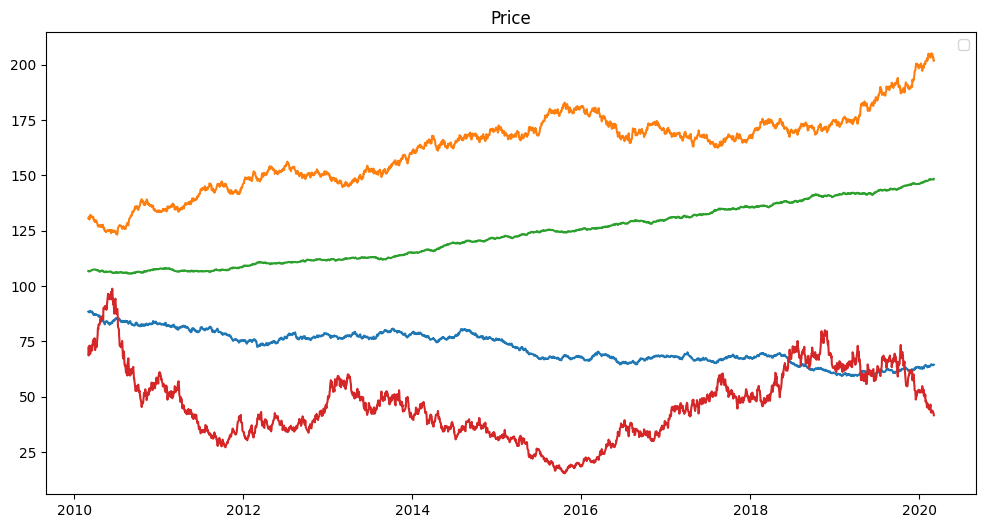

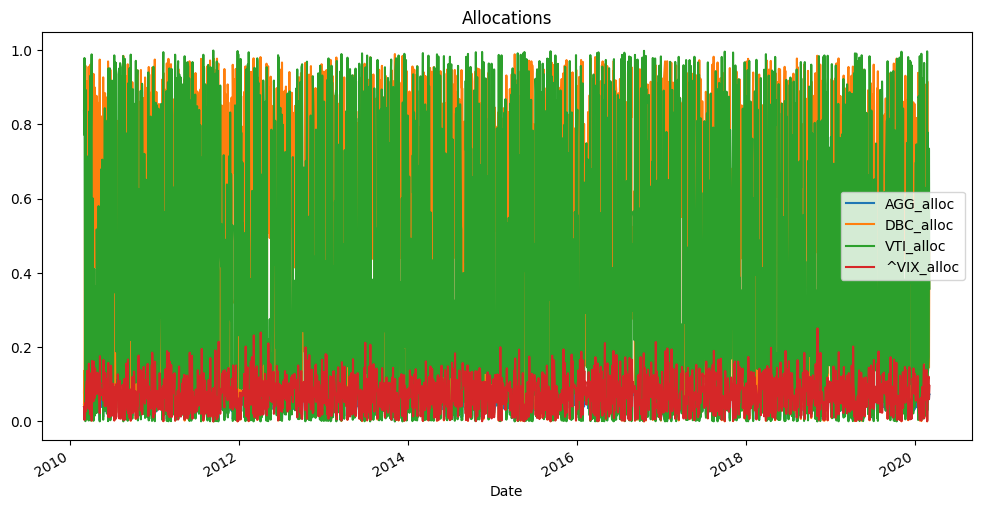

nb de jours d'investissement: 2520
annualized return: 0.02519833114832104
sharpe ratio: 0.7275987344352072
std deviation: 0.03504846535837332
downside_risk:  0.02326665127156771 


In [4]:
model = NN_Sharpe(model_name="RNN",  input_size=4, hidden_size=64, output_size=4, num_layers=1, temperature=0.1)

trainer = Trainer(model, synthetic=True, weight_decay=0.2, scheduler_gamma=0, lr=0.001)

out = trainer.train(verbose=True, epochs=50, overlap=True, batch_size=64, rolling_window=252, retrain_years=2, initial_train_years=4)

plot_results(out, trainer)
#trainer.plot_results(out)

[*********************100%***********************]  4 of 4 completed
Training period from 2006-03-01 00:00:00 to 2010-03-03 00:00:00
Investment period from 2010-03-03 00:00:00 to 2012-03-01 00:00:00


100%|██████████| 50/50 [00:21<00:00,  2.28it/s]


Training period from 2010-03-03 00:00:00 to 2012-03-01 00:00:00
Investment period from 2012-03-01 00:00:00 to 2014-03-05 00:00:00


100%|██████████| 50/50 [00:07<00:00,  7.08it/s]


Training period from 2012-03-01 00:00:00 to 2014-03-05 00:00:00
Investment period from 2014-03-05 00:00:00 to 2016-03-04 00:00:00


100%|██████████| 50/50 [00:07<00:00,  7.10it/s]


Training period from 2014-03-05 00:00:00 to 2016-03-04 00:00:00
Investment period from 2016-03-04 00:00:00 to 2018-03-06 00:00:00


100%|██████████| 50/50 [00:07<00:00,  7.07it/s]


Training period from 2016-03-04 00:00:00 to 2018-03-06 00:00:00
Investment period from 2018-03-06 00:00:00 to 2020-03-06 00:00:00


100%|██████████| 50/50 [00:07<00:00,  7.04it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


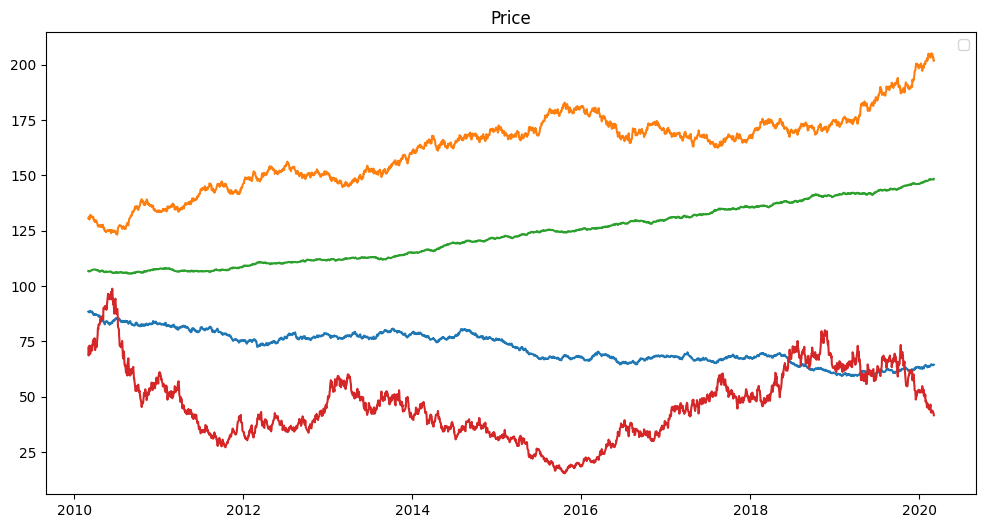

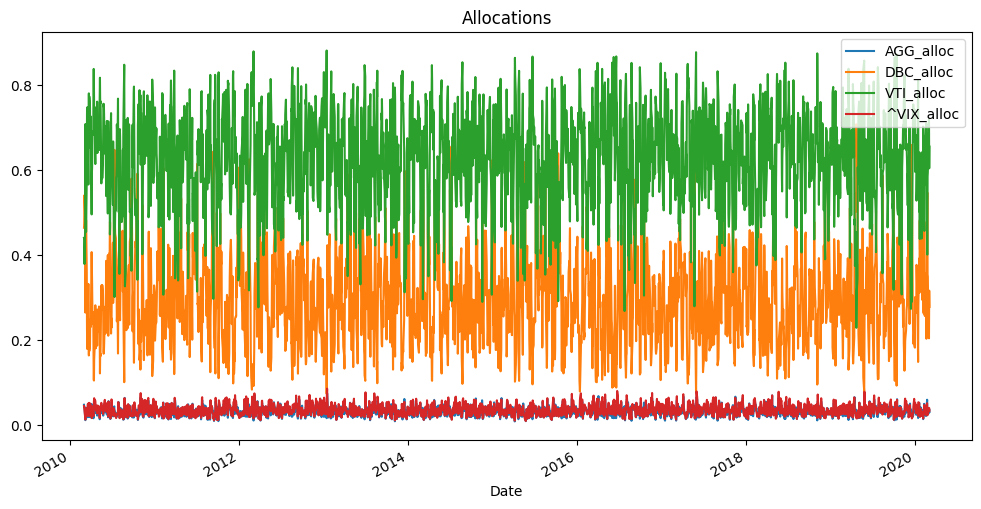

nb de jours d'investissement: 2520
annualized return: 0.03221628475149596
sharpe ratio: 1.5865036841036044
std deviation: 0.020114948289789405
downside_risk:  0.012698807759595303 


In [5]:
model = NN_Sharpe(model_name="GRU",  input_size=4, hidden_size=64, output_size=4, num_layers=1, temperature=1)

trainer = Trainer(model, synthetic=True, weight_decay=0.01, scheduler_gamma=0, lr=0.001)

out = trainer.train(verbose=True, epochs=50, overlap=True, batch_size=64, rolling_window=252, retrain_years=2, initial_train_years=4)

plot_results(out, trainer)
#trainer.plot_results(out)

#### Markowitz portfolio optimization

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


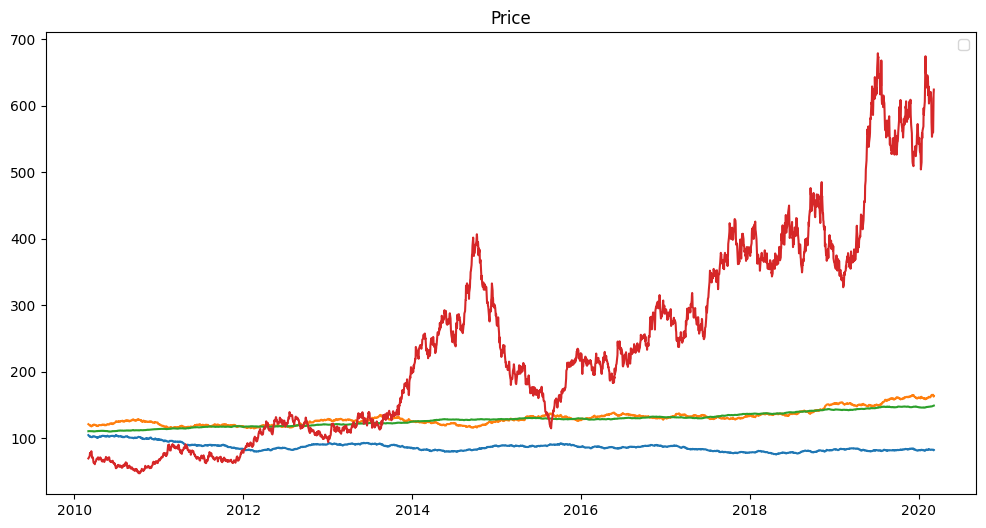

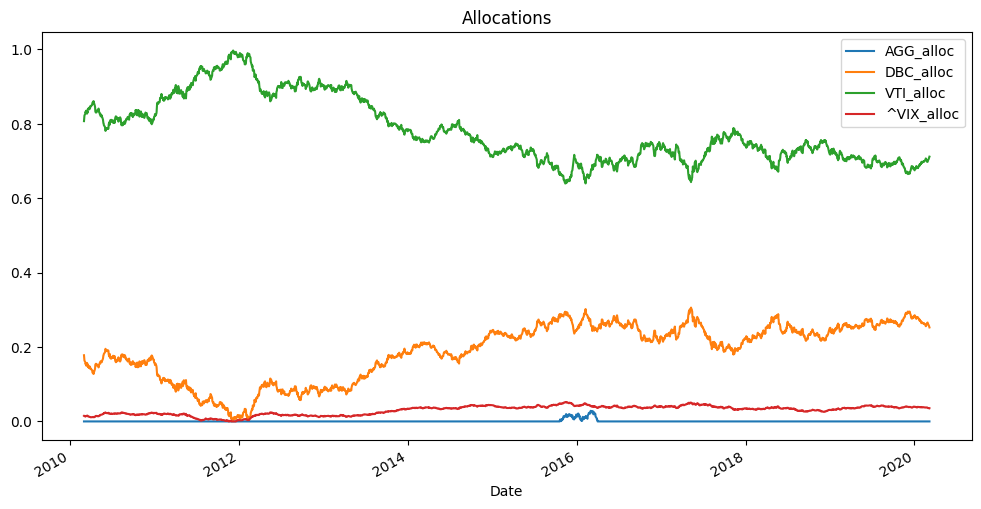

nb de jours d'investissement: 2521
annualized return: 0.03805129100094562
sharpe ratio: 2.3550653587578303
std deviation: 0.015912296094902457
downside_risk:  0.009372016459755897 


In [41]:
out = trainer.markov_portfolio(rolling_window=1000)
plot_results(out, trainer)

We can see here that both model lead to an allocation around [0.8, 0.2, 0, 0] (which is the solution that maximise the expectation of the sharp ratio on this setup)


We see that the LSTM model is pretty close to the optimal solution on this framework. But now we can see if the LSTM have better results on real data, where we have no garentee that the markowitz portfolio is optimal (in the real world, the increments does not follow a perfect gaussian multivariate distribution...)

# Test on a real dataset

#### LSTM portfolio optimization

[*********************100%***********************]  4 of 4 completed
Training period from 2006-03-01 00:00:00 to 2010-03-03 00:00:00
Investment period from 2010-03-03 00:00:00 to 2012-03-01 00:00:00


100%|██████████| 3/3 [00:01<00:00,  1.97it/s]


Training period from 2010-03-03 00:00:00 to 2012-03-01 00:00:00
Investment period from 2012-03-01 00:00:00 to 2014-03-05 00:00:00


100%|██████████| 3/3 [00:00<00:00,  5.74it/s]


Training period from 2012-03-01 00:00:00 to 2014-03-05 00:00:00
Investment period from 2014-03-05 00:00:00 to 2016-03-04 00:00:00


100%|██████████| 3/3 [00:00<00:00,  6.15it/s]


Training period from 2014-03-05 00:00:00 to 2016-03-04 00:00:00
Investment period from 2016-03-04 00:00:00 to 2018-03-06 00:00:00


100%|██████████| 3/3 [00:00<00:00,  6.03it/s]


Training period from 2016-03-04 00:00:00 to 2018-03-06 00:00:00
Investment period from 2018-03-06 00:00:00 to 2020-03-06 00:00:00


100%|██████████| 3/3 [00:00<00:00,  6.52it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


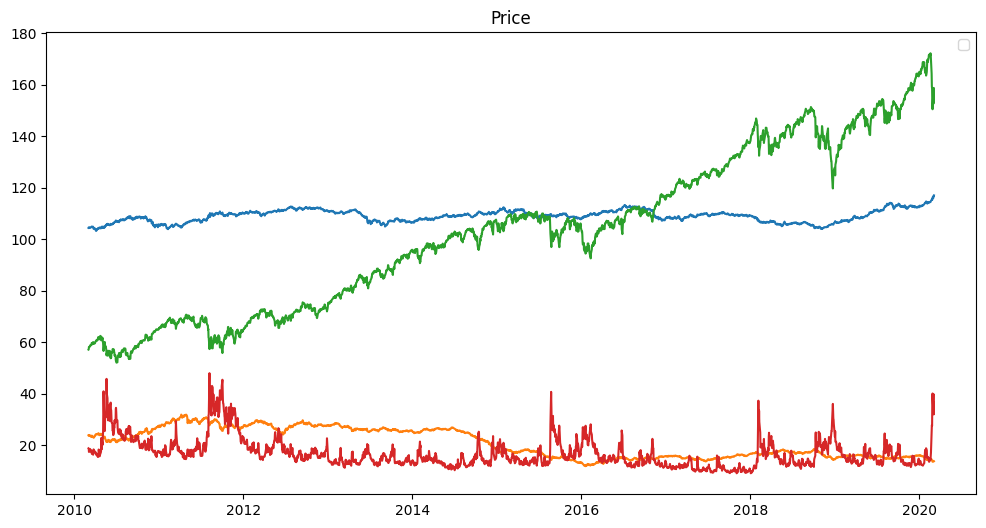

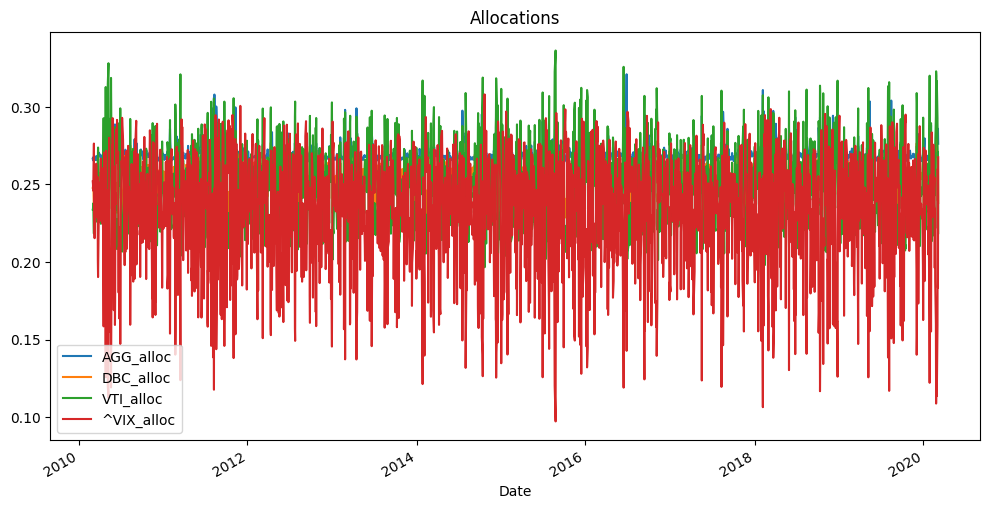

nb de jours d'investissement: 2520
annualized return: 0.269831119305723
sharpe ratio: 1.0817346902050458
std deviation: 0.24910363503754762
downside_risk:  0.11721888726633739 


In [61]:
model = NN_Sharpe(model_name="LSTM",  input_size=4, hidden_size=64, output_size=4, num_layers=1, temperature=1)

trainer = Trainer(model, weight_decay=0.2, scheduler_gamma=0, lr=0.001)

out = trainer.train(verbose=True, epochs=3, overlap=True, batch_size=64, rolling_window=252, retrain_years=2, initial_train_years=4)

plot_results(out, trainer)
#trainer.plot_results(out)
#trainer.plot_results(out)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


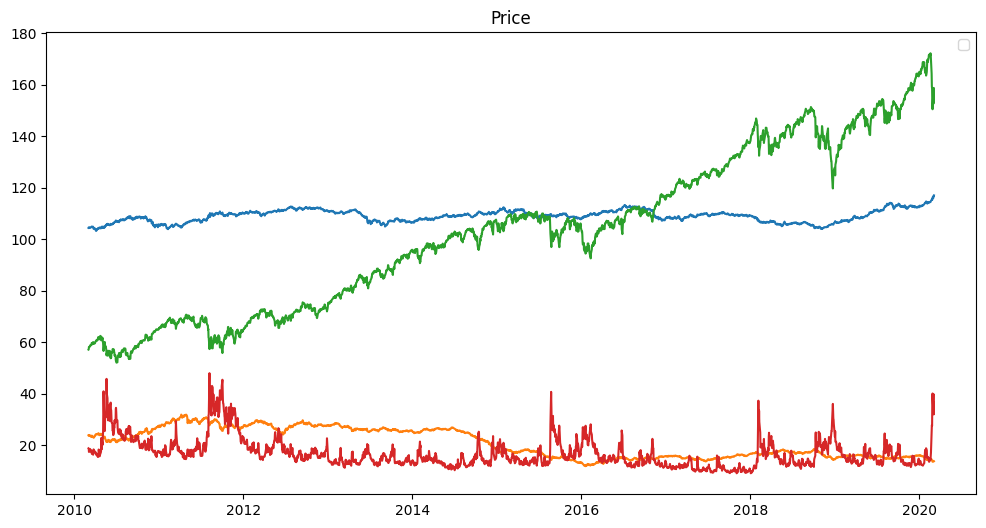

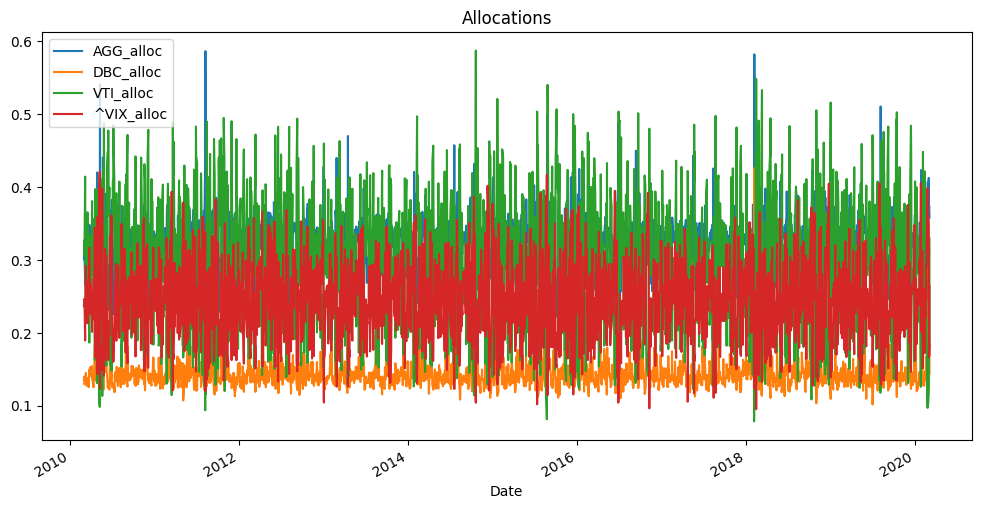

nb de jours d'investissement: 2520
annualized return: 0.1658819269180365
sharpe ratio: 0.6283328855965817
std deviation: 0.32477044461292803
downside_risk:  0.17481432437632444 


In [55]:
plot_results(out, trainer)

#### Markowitz Portfolio optimization

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


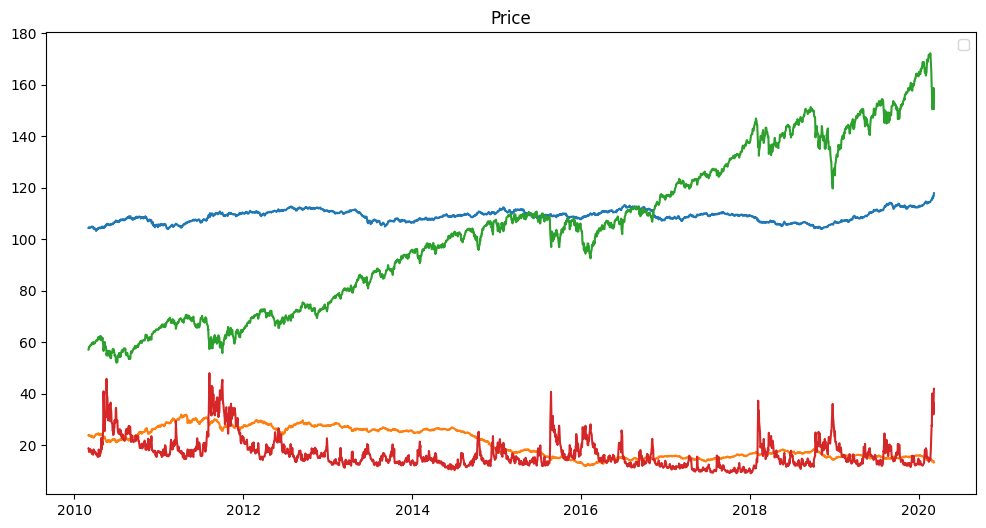

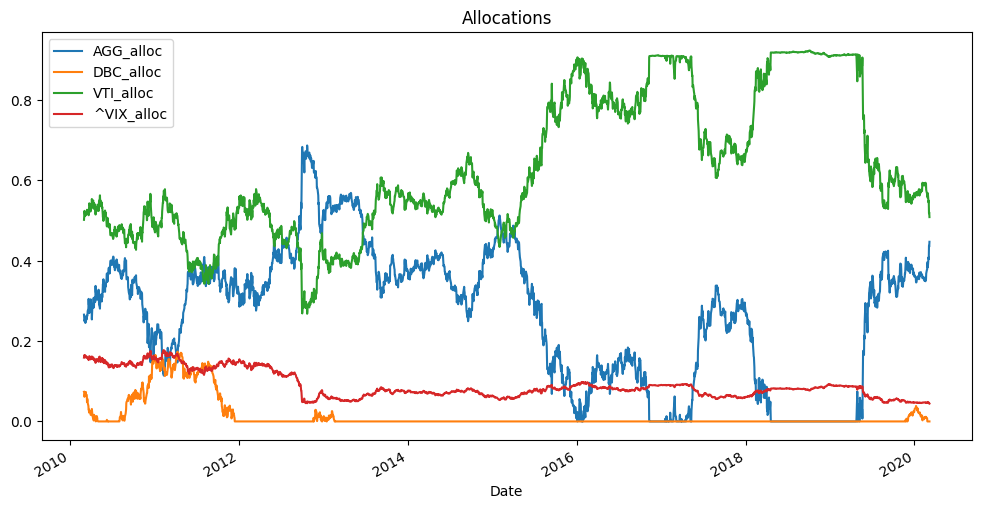

nb de jours d'investissement: 2521
annualized return: 0.1361146794369179
sharpe ratio: 1.67506096759165
std deviation: 0.07801087686577664
downside_risk:  0.047567929393924506 


In [46]:
out = trainer.markov_portfolio(rolling_window=1000)
plot_results(out, trainer)